# In this notebook, we only focus on cleaning the eviction dataset from:

https://data.cityofnewyork.us/City-Government/Evictions/6z8x-wfk4/data_preview

The explainations of the data can be found here: https://data.cityofnewyork.us/City-Government/Evictions/6z8x-wfk4/about_data

- The originally downloaded dataset ranges from 2017 - 2025.02.22, but in this notebook, we will ignore the 2025 data, and only focus on 2017 - 2024
- We went from 104,457 records and 20 columns, to 88,471 records 19 columns (subtracted 2 and added 1).
- We treat "court_index_number" as primary keys and dropped records that have the same cour index number but with earlier eviction exected dates. "cour_index_number" is also the primary key on the website.
- We only focus on residential records and drop commercial records (the ratio is roughly 9:1)
- We dropped rows that have NaN in geo data columns
- We included bar charts to see the spatial and temporal trends and will include them later in the formal analysis

Finally, we saved the cleaned dataset to google drive and will do the visual and data exploration, and eventually test out hypothesis regarding complaints and evictions, clusterings in NYC, and predictions in different notebooks later.

In [471]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import os
import io
import folium
import geopandas as gpd
import seaborn as sns

# suppress warning
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [472]:
# # load eviction data
# from google.colab import files
# uploaded = files.upload()

# uploaded manually

from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/X999/Evictions.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [473]:
# evictions = pd.read_csv(io.BytesIO(uploaded['Evictions_20240918.csv']))
evictions_df_row = pd.read_csv(file_path)

In [474]:
evictions_df = evictions_df_row

In [475]:
evictions_df.head(1)

,Court Index Number,Docket Number,Eviction Address,Eviction Apartment Number,Executed Date,Marshal First Name,Marshal Last Name,Residential/Commercial,BOROUGH,Eviction Postcode,Ejectment,Eviction/Legal Possession,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,22379/19,354582,2915 LA SALLE AVENUE,3R,08/14/2019,Thomas,Bia,Residential,BRONX,10461,Not an Ejectment,Possession,40.839044,-73.830768,10.0,13.0,184.0,2073762.0,2.053580e+09,Schuylerville-Throgs Neck-Edgewater Park


In [476]:
evictions_df.shape

(104457, 20)

In [477]:
evictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104457 entries, 0 to 104456
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Court Index Number         104457 non-null  object 
 1   Docket Number              104457 non-null  int64  
 2   Eviction Address           104457 non-null  object 
 3   Eviction Apartment Number  88714 non-null   object 
 4   Executed Date              104457 non-null  object 
 5   Marshal First Name         104457 non-null  object 
 6   Marshal Last Name          104457 non-null  object 
 7   Residential/Commercial     104457 non-null  object 
 8   BOROUGH                    104457 non-null  object 
 9   Eviction Postcode          104457 non-null  int64  
 10  Ejectment                  104457 non-null  object 
 11  Eviction/Legal Possession  104457 non-null  object 
 12  Latitude                   95049 non-null   float64
 13  Longitude                  95

In [478]:
evictions_df.columns

Index(['Court Index Number', 'Docket Number ', 'Eviction Address',
       'Eviction Apartment Number', 'Executed Date', 'Marshal First Name',
       'Marshal Last Name', 'Residential/Commercial', 'BOROUGH',
       'Eviction Postcode', 'Ejectment', 'Eviction/Legal Possession',
       'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'BIN', 'BBL', 'NTA'],
      dtype='object')

In [479]:
evictions_df['Residential/Commercial'].value_counts()

,count
Residential/Commercial,
Residential,94907
Commercial,9550


In [480]:
# percentage
evictions_df['Residential/Commercial'].value_counts(normalize=True) * 100

,proportion
Residential/Commercial,
Residential,90.857482
Commercial,9.142518


#### Residential/Commercial graph

In [481]:
len(evictions_df)

104457

In [482]:
evictions_df["Marshal Last Name"].head()
# will drop this coloumn

,Marshal Last Name
0,Bia
1,Rose
2,Bia
3,Guida
4,Grossman


In [483]:
# cleaning functions (later to drop commercials)
def drop_columns(df, columns):
    df.drop(columns, axis=1, inplace=True)

# convert all the column names into lower case, strip the final space, and change the spaces betwen words to "_"
def clean_column_names(df):
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.strip().str.replace(' ', '_')
    return df

In [484]:
evictions_df = clean_column_names(evictions_df)

In [485]:
# drop rows that represent commercial units, instead of residentail units
# drop columns that are irrelevant, such as "Marshal Last Name", and "Marshal first Name"

# drop_rows_by_value(evictions_df, "Residential/Commercial", 'Commercial')
drop_columns(evictions_df, ["marshal_last_name", "marshal_first_name"])
evictions_df = evictions_df[evictions_df['residential/commercial'] != 'Commercial']

In [486]:
evictions_df.shape
# original dataset's volumn:
# 104467, 20

(94907, 18)

In [487]:
evictions_df.columns

Index(['court_index_number', 'docket_number', 'eviction_address',
       'eviction_apartment_number', 'executed_date', 'residential/commercial',
       'borough', 'eviction_postcode', 'ejectment',
       'eviction/legal_possession', 'latitude', 'longitude', 'community_board',
       'council_district', 'census_tract', 'bin', 'bbl', 'nta'],
      dtype='object')

In [488]:
evictions_df["residential/commercial"].unique()
evictions_df.shape

(94907, 18)

In [489]:
print(evictions_df.isnull().sum())

court_index_number               0
docket_number                    0
eviction_address                 0
eviction_apartment_number    10896
executed_date                    0
residential/commercial           0
borough                          0
eviction_postcode                0
ejectment                        0
eviction/legal_possession        0
latitude                      6257
longitude                     6257
community_board               6257
council_district              6257
census_tract                  6257
bin                           6436
bbl                           6436
nta                           6257
dtype: int64


In [490]:
type(evictions_df["eviction_apartment_number"][0])

str

In [491]:
# though "eviction apartment number" column has NaN, still keep the strings there, because they might be interesting
# to look at for certain case studies later
evictions_df['eviction_apartment_number'].fillna("unknown", inplace=True)

In [492]:
print(evictions_df.isnull().sum())

court_index_number              0
docket_number                   0
eviction_address                0
eviction_apartment_number       0
executed_date                   0
residential/commercial          0
borough                         0
eviction_postcode               0
ejectment                       0
eviction/legal_possession       0
latitude                     6257
longitude                    6257
community_board              6257
council_district             6257
census_tract                 6257
bin                          6436
bbl                          6436
nta                          6257
dtype: int64


In [493]:
evictions_df.dropna(inplace=True)

In [494]:
# sanity check
evictions_df.shape, \
evictions_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88471 entries, 0 to 104456
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   court_index_number         88471 non-null  object 
 1   docket_number              88471 non-null  int64  
 2   eviction_address           88471 non-null  object 
 3   eviction_apartment_number  88471 non-null  object 
 4   executed_date              88471 non-null  object 
 5   residential/commercial     88471 non-null  object 
 6   borough                    88471 non-null  object 
 7   eviction_postcode          88471 non-null  int64  
 8   ejectment                  88471 non-null  object 
 9   eviction/legal_possession  88471 non-null  object 
 10  latitude                   88471 non-null  float64
 11  longitude                  88471 non-null  float64
 12  community_board            88471 non-null  float64
 13  council_district           88471 non-null  float64

((88471, 18), None)

In [495]:
evictions_df["residential/commercial"].unique()

array(['Residential'], dtype=object)

In [500]:
evictions_df.shape, \
evictions_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88341 entries, 0 to 104456
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   court_index_number         88341 non-null  object 
 1   docket_number              88341 non-null  int64  
 2   eviction_address           88341 non-null  object 
 3   eviction_apartment_number  88341 non-null  object 
 4   executed_date              88341 non-null  object 
 5   residential/commercial     88341 non-null  object 
 6   borough                    88341 non-null  object 
 7   eviction_postcode          88341 non-null  int64  
 8   ejectment                  88341 non-null  object 
 9   eviction/legal_possession  88341 non-null  object 
 10  latitude                   88341 non-null  float64
 11  longitude                  88341 non-null  float64
 12  community_board            88341 non-null  float64
 13  council_district           88341 non-null  float64

((88341, 18), None)

In [501]:
len(evictions_df.court_index_number.unique()), \
len(evictions_df.docket_number.unique())

(82473, 75088)

In [502]:
# 82473, 75088

In [503]:
evictions_df.drop_duplicates(inplace=True)

In [504]:
len(evictions_df.court_index_number.unique()), \
len(evictions_df.docket_number.unique())

(82473, 75088)

In [505]:
# since all rows are residential now, drop the column that indicates if it is residential or commercial
evictions_df.drop(columns=['residential/commercial'], inplace=True)

In [506]:
# drop duplicates based on court_index_number
# evictions_df = evictions_df.drop_duplicates(subset=['court_index_number'])

In [507]:
evictions_df.columns

Index(['court_index_number', 'docket_number', 'eviction_address',
       'eviction_apartment_number', 'executed_date', 'borough',
       'eviction_postcode', 'ejectment', 'eviction/legal_possession',
       'latitude', 'longitude', 'community_board', 'council_district',
       'census_tract', 'bin', 'bbl', 'nta'],
      dtype='object')

In [508]:
evictions_df.shape, \
evictions_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88341 entries, 0 to 104456
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   court_index_number         88341 non-null  object 
 1   docket_number              88341 non-null  int64  
 2   eviction_address           88341 non-null  object 
 3   eviction_apartment_number  88341 non-null  object 
 4   executed_date              88341 non-null  object 
 5   borough                    88341 non-null  object 
 6   eviction_postcode          88341 non-null  int64  
 7   ejectment                  88341 non-null  object 
 8   eviction/legal_possession  88341 non-null  object 
 9   latitude                   88341 non-null  float64
 10  longitude                  88341 non-null  float64
 11  community_board            88341 non-null  float64
 12  council_district           88341 non-null  float64
 13  census_tract               88341 non-null  float64

((88341, 17), None)

In [509]:
# find some rows that have the same court index number
duplicate_groups = evictions_df.groupby('court_index_number').filter(lambda x: len(x) > 1)
duplicate_groups.head(2)

,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
1,55120/17,22819,310 EAST 2ND STREET,3H,01/25/2018,MANHATTAN,10009,Not an Ejectment,Possession,40.720081,-73.979203,3.0,2.0,2202.0,1088845.0,1.003720e+09,Lower East Side
2,308641/22,366619,3003 WALLACE AVENUE,1,11/13/2023,BRONX,10467,Not an Ejectment,Possession,40.869928,-73.864326,12.0,15.0,338.0,2055595.0,2.045700e+09,Bronxdale


In [510]:
check = evictions_df[evictions_df["court_index_number"] == '307019/20']

# display the filtered rows
check

,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
63441,307019/20,108457,505 WEST 54TH STREET,1111,08/16/2022,MANHATTAN,10019,Not an Ejectment,Possession,40.767339,-73.9903,4.0,6.0,135.0,1087122.0,1.010830e+09,Clinton
72514,307019/20,108457,505 WEST 54TH STREET,1111,09/28/2022,MANHATTAN,10019,Not an Ejectment,Possession,40.767339,-73.9903,4.0,6.0,135.0,1087122.0,1.010830e+09,Clinton


In [511]:
evictions_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88341 entries, 0 to 104456
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   court_index_number         88341 non-null  object 
 1   docket_number              88341 non-null  int64  
 2   eviction_address           88341 non-null  object 
 3   eviction_apartment_number  88341 non-null  object 
 4   executed_date              88341 non-null  object 
 5   borough                    88341 non-null  object 
 6   eviction_postcode          88341 non-null  int64  
 7   ejectment                  88341 non-null  object 
 8   eviction/legal_possession  88341 non-null  object 
 9   latitude                   88341 non-null  float64
 10  longitude                  88341 non-null  float64
 11  community_board            88341 non-null  float64
 12  council_district           88341 non-null  float64
 13  census_tract               88341 non-null  float64

In [512]:
# drop duplicates based on Court Index Number
# cleaned_df = evictions_df.drop_duplicates(subset=['court_index_number'])

In [513]:
evictions_df['executed_date'] = pd.to_datetime(evictions_df['executed_date'])

In [514]:
evictions_df.sort_values(by=['court_index_number', 'executed_date'], inplace=True)

In [515]:
evictions_df = evictions_df.drop_duplicates(subset=['court_index_number'], keep='last')

In [516]:
# only keep the relevant ones
start_date = '2017-01-01'
end_date = '2024-12-31'
date_mask = (evictions_df['executed_date'] >= start_date) & (evictions_df['executed_date'] <= end_date)

In [517]:
evictions_df = evictions_df[date_mask]
sorted_df = evictions_df.sort_values('executed_date')

In [518]:
evictions_df.info(), \
len(evictions_df)

<class 'pandas.core.frame.DataFrame'>
Index: 80420 entries, 7797 to 21704
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   court_index_number         80420 non-null  object        
 1   docket_number              80420 non-null  int64         
 2   eviction_address           80420 non-null  object        
 3   eviction_apartment_number  80420 non-null  object        
 4   executed_date              80420 non-null  datetime64[ns]
 5   borough                    80420 non-null  object        
 6   eviction_postcode          80420 non-null  int64         
 7   ejectment                  80420 non-null  object        
 8   eviction/legal_possession  80420 non-null  object        
 9   latitude                   80420 non-null  float64       
 10  longitude                  80420 non-null  float64       
 11  community_board            80420 non-null  float64       
 12  counci

(None, 80420)

In [519]:
sorted_df

,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
26688,34859/16,53416,3476 SEYMOUR AVENUE,3-B,2017-01-03,BRONX,10469,Not an Ejectment,Possession,40.877620,-73.849806,12.0,12.0,386.0,2117041.0,2.047200e+09,Eastchester-Edenwald-Baychester
66493,B57808/16,74242,1426 BRYANT AVENUE,10 AKA 2ND FL UNIT,2017-01-03,BRONX,10459,Not an Ejectment,Possession,40.830691,-73.888555,3.0,17.0,123.0,2099901.0,2.029990e+09,Crotona Park East
47644,N069212/14,355977,1309 5TH AVENUE,24H,2017-01-03,MANHATTAN,10029,Not an Ejectment,Possession,40.797309,-73.948901,11.0,9.0,17402.0,1078884.0,1.016160e+09,East Harlem South
15788,K065455/16,367441,458 EAST 51 STREET,6A,2017-01-03,BROOKLYN,11203,Not an Ejectment,Possession,40.650624,-73.929261,17.0,45.0,862.0,3102875.0,3.046980e+09,Rugby-Remsen Village
16805,33992/16,458984,580 EAST 168TH STREE T,*,2017-01-03,BRONX,10456,Not an Ejectment,Possession,40.830494,-73.904108,3.0,16.0,185.0,2004234.0,2.026110e+09,Morrisania-Melrose
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75414,308123/24,23218,45 BRADHURST AVENUE APT 1,1,2024-12-26,MANHATTAN,10030,Not an Ejectment,Possession,40.822848,-73.943318,9.0,9.0,227.0,1061113.0,1.020510e+09,Hamilton Heights
78140,314456/24,22735,370 WEST 52ND STREET APT 3-B,3-B,2024-12-26,MANHATTAN,10019,Not an Ejectment,Possession,40.764435,-73.987336,4.0,3.0,133.0,1078889.0,1.010420e+09,Clinton
51668,308611/20,21515,1629 ST JOHNS PLACE APT. 4F,4F,2024-12-27,BROOKLYN,11233,Not an Ejectment,Possession,40.670179,-73.923408,8.0,41.0,359.0,3036936.0,3.013810e+09,Crown Heights North
71721,306966/24,22953,119 BAXTER STREET APARTMENT 8R,8R,2024-12-27,MANHATTAN,10013,Not an Ejectment,Possession,40.718065,-73.998975,2.0,1.0,41.0,1079542.0,1.002060e+09,SoHo-TriBeCa-Civic Center-Little Italy


In [520]:
# final eviction df sanity check
evictions_df.shape, \
evictions_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80420 entries, 7797 to 21704
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   court_index_number         80420 non-null  object        
 1   docket_number              80420 non-null  int64         
 2   eviction_address           80420 non-null  object        
 3   eviction_apartment_number  80420 non-null  object        
 4   executed_date              80420 non-null  datetime64[ns]
 5   borough                    80420 non-null  object        
 6   eviction_postcode          80420 non-null  int64         
 7   ejectment                  80420 non-null  object        
 8   eviction/legal_possession  80420 non-null  object        
 9   latitude                   80420 non-null  float64       
 10  longitude                  80420 non-null  float64       
 11  community_board            80420 non-null  float64       
 12  counci

((80420, 17), None)

In [521]:
# evictions_df.head()

#### For the write-up: do a check on each year's eviction numbers and visuals

1. numbers
2. bar chart showing the annual trend
3.

In [524]:
evictions_df['year'] = evictions_df['executed_date'].dt.year
df_2017 = evictions_df[evictions_df['year'] == 2017]
print("2017", len(df_2017))
df_2018 = evictions_df[evictions_df['year'] == 2018]
print("2018", len(df_2018))
df_2019 = evictions_df[evictions_df['year'] == 2019]
print("2019", len(df_2019))
df_2020 = evictions_df[evictions_df['year'] == 2020]
print("2020", len(df_2020))
df_2021 = evictions_df[evictions_df['year'] == 2021]
print("2021", len(df_2021))
df_2022 = evictions_df[evictions_df['year'] == 2022]
print("2022", len(df_2022))
df_2023 = evictions_df[evictions_df['year'] == 2023]
print("2023", len(df_2023))
df_2024 = evictions_df[evictions_df['year'] == 2024]
print("2024", len(df_2024))

2017 17860
2018 17186
2019 14903
2020 2704
2021 122
2022 3512
2023 10476
2024 13657


In [525]:
# plt.style.use('seaborn')
pastel_colors = sns.color_palette("pastel")

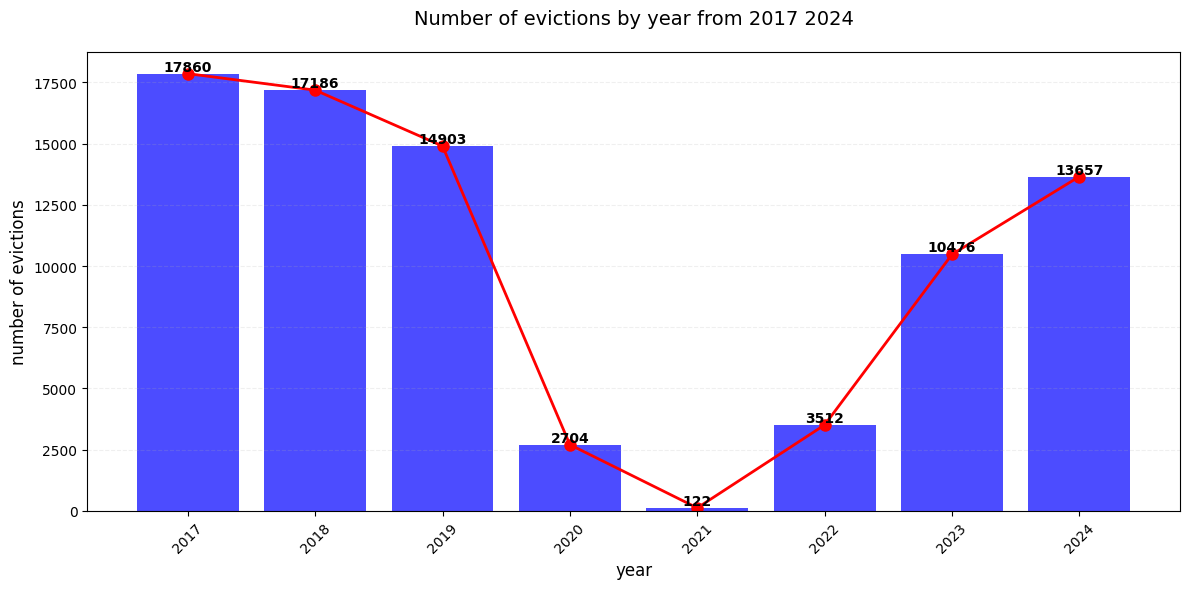

In [526]:
# count evictions by year
yearly_counts = evictions_df.groupby(evictions_df['executed_date'].dt.year).size()
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(yearly_counts.index, yearly_counts.values, color='blue', alpha=0.7)
ax.plot(yearly_counts.index, yearly_counts.values, color='red', marker='o', linewidth=2, markersize=8,)

# plot
plt.title('Number of evictions by year from 2017 2024', fontsize=14, pad=20)
plt.xlabel('year', fontsize=12)
plt.ylabel('number of evictions', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.2)
plt.xticks(yearly_counts.index, rotation=45)

# value labels
for i, v in enumerate(yearly_counts):
    ax.text(yearly_counts.index[i], v, str(v),
            ha='center', va='bottom',
            fontweight='bold')

plt.tight_layout()
plt.show()

In [527]:
print("Evictions per year:")
print(yearly_counts)

Evictions per year:
executed_date
2017    17860
2018    17186
2019    14903
2020     2704
2021      122
2022     3512
2023    10476
2024    13657
dtype: int64


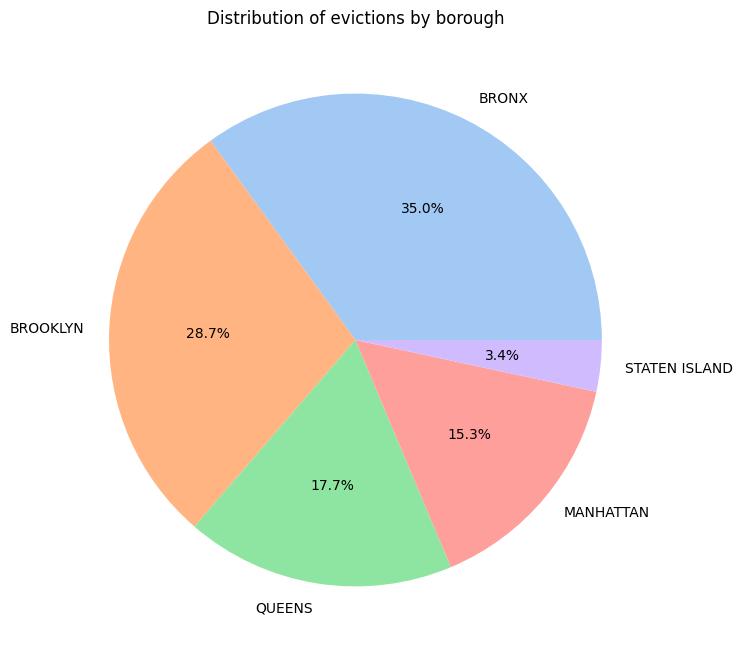

<Figure size 1200x1600 with 0 Axes>

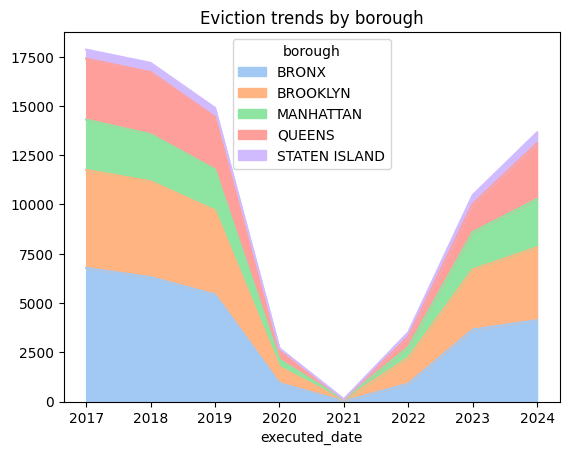

In [528]:
# borough-wise distribution
# Pie Chart
plt.figure(figsize=(10, 8))
evictions_df['borough'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette("pastel"))
plt.title('Distribution of evictions by borough')
plt.ylabel('')
plt.show()

# borough trends over time
# stacked area chart
plt.figure(figsize=(12, 16))
borough_time = evictions_df.groupby([evictions_df['executed_date'].dt.year, 'borough']).size().unstack()
borough_time.plot(kind='area',
                 stacked=True,
                 color=pastel_colors)
plt.title('Eviction trends by borough')
plt.show()

In [553]:
# summary
borough_counts = evictions_df['borough'].value_counts()
total_evictions = len(evictions_df)

print("Borough-wise distribution summary:")
print("-" * 50)
print("Total number of evictions:", total_evictions)
print("Breakdown by borough:")
for borough, count in borough_counts.items():
   percentage = (count / total_evictions) * 100
   print(f"{borough.title()::<15} | Count: {count:>6} | Percentage: {percentage:>6.1f}%")

# borough trends
print("Borough trends by year:")
print("-" * 50)
print("Yearly counts by borough:")
print(borough_time.to_string())

# additional statistics
print("Summary statistics by borough:")
print("-" * 50)
for borough in borough_time.columns:
   total = borough_time[borough].sum()
   avg = borough_time[borough].mean()
   max_year = borough_time[borough].idxmax()
   max_count = borough_time[borough].max()

   print(f"{borough.title()}:")
   print(f"Total evictions: {total:,.0f}")
   print(f"Average yearly evictions: {avg:,.1f}")
   print(f"Peak year: {max_year} with {max_count:,.0f} evictions")

# year over year changes
print("Year-over-year changes:")
print("-" * 50)
yearly_changes = borough_time.pct_change() * 100
print(yearly_changes.round(1).to_string())

Borough-wise distribution summary:
--------------------------------------------------
Total number of evictions: 80420
Breakdown by borough:
Bronx:::::::::: | Count:  28155 | Percentage:   35.0%
Brooklyn::::::: | Count:  23050 | Percentage:   28.7%
Queens::::::::: | Count:  14202 | Percentage:   17.7%
Manhattan:::::: | Count:  12301 | Percentage:   15.3%
Staten Island:: | Count:   2712 | Percentage:    3.4%
Borough trends by year:
--------------------------------------------------
Yearly counts by borough:
borough        BRONX  BROOKLYN  MANHATTAN  QUEENS  STATEN ISLAND
executed_date                                                   
2017            6776      4973       2556    3092            463
2018            6312      4867       2389    3151            467
2019            5432      4268       2081    2662            460
2020             935       824        369     502             74
2021              12        49         21      18             22
2022             908      1317   

#### monthly changes bar/line chart

In [529]:
evictions_df['month_year'] = evictions_df['executed_date'].dt.to_period('M')
monthly_trend = evictions_df.groupby('month_year').size().reset_index()
monthly_trend.columns = ['month_year', 'count']

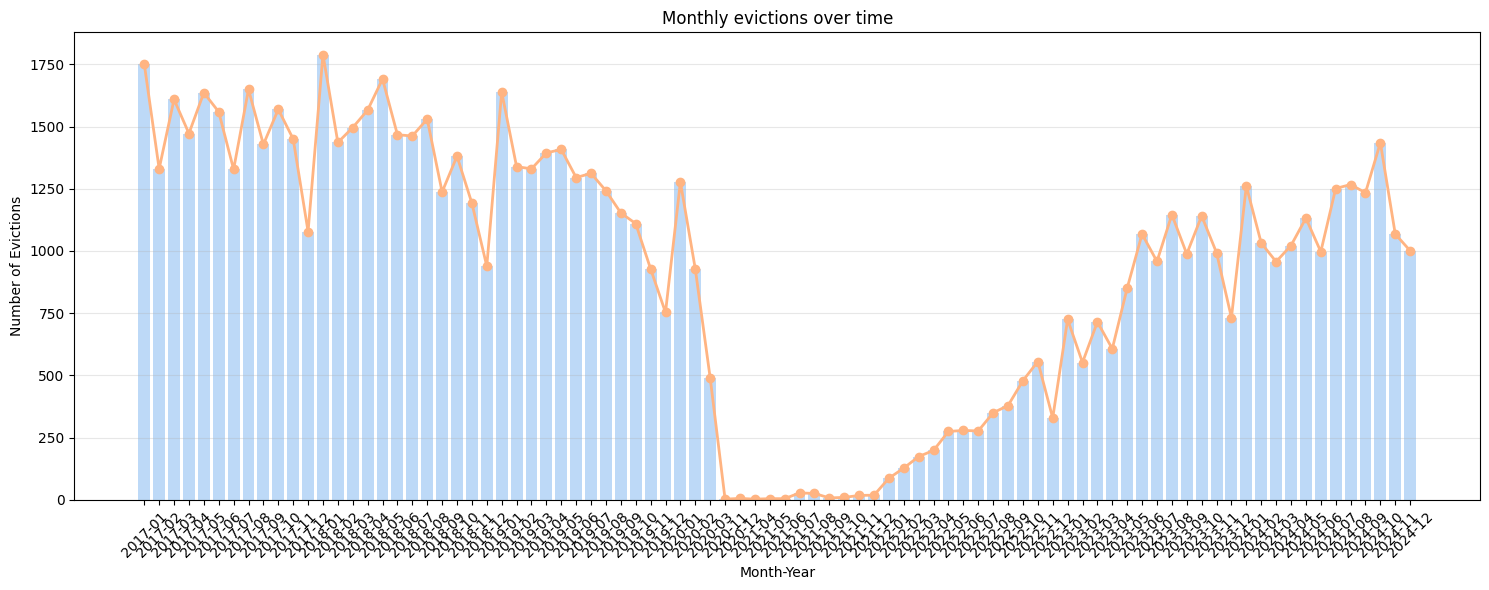

In [550]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(monthly_trend['month_year'].astype(str),
       monthly_trend['count'],
       color=sns.color_palette("pastel")[0],
       alpha=0.7)

ax.plot(monthly_trend['month_year'].astype(str),
        monthly_trend['count'],
        color=sns.color_palette("pastel")[1],
        marker='o',
        linewidth=2,
        markersize=6)

plt.title('Monthly evictions over time')
plt.xlabel('Month-Year')
plt.ylabel('Number of Evictions')
plt.xticks(rotation=45)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [554]:
monthly_trend = monthly_trend.sort_values('month_year')

print("Monthly Eviction Counts:")
print("Month-Year | Number of Evictions")
print("-" * 35)
for _, row in monthly_trend.iterrows():
    print(f"{row['month_year']} | {row['count']:^17}")

# summary statistics
print("Summary Statistics by month - year:")
print(f"Total number of evictions: {monthly_trend['count'].sum():,}")
print(f"Average monthly evictions: {monthly_trend['count'].mean():.1f}")
print(f"Maximum monthly evictions: {monthly_trend['count'].max()} (in {monthly_trend.loc[monthly_trend['count'].idxmax(), 'month_year']})")
print(f"Minimum monthly evictions: {monthly_trend['count'].min()} (in {monthly_trend.loc[monthly_trend['count'].idxmin(), 'month_year']})")

# month-over-month changes
monthly_trend['change'] = monthly_trend['count'].diff()
monthly_trend['pct_change'] = monthly_trend['count'].pct_change() * 100

print("Largest monthly changes:")
print("Month-Year | Change | % Change")
print("-" * 40)
for _, row in monthly_trend.nlargest(10, 'change').iterrows():
    print(f"{row['month_year']} | {row['change']:^6.0f} | {row['pct_change']:^6.1f}%")

print("Largest monthly decreases:")
print("Month-Year | Change | % Change")
print("-" * 40)
for _, row in monthly_trend.nsmallest(10, 'change').iterrows():
    print(f"{row['month_year']} | {row['change']:^6.0f} | {row['pct_change']:^6.1f}%")

Monthly Eviction Counts:
Month-Year | Number of Evictions
-----------------------------------
2017-01 |       1752       
2017-02 |       1330       
2017-03 |       1609       
2017-04 |       1472       
2017-05 |       1636       
2017-06 |       1559       
2017-07 |       1328       
2017-08 |       1649       
2017-09 |       1428       
2017-10 |       1569       
2017-11 |       1450       
2017-12 |       1078       
2018-01 |       1789       
2018-02 |       1436       
2018-03 |       1496       
2018-04 |       1566       
2018-05 |       1691       
2018-06 |       1467       
2018-07 |       1462       
2018-08 |       1530       
2018-09 |       1237       
2018-10 |       1381       
2018-11 |       1192       
2018-12 |        939       
2019-01 |       1639       
2019-02 |       1339       
2019-03 |       1330       
2019-04 |       1394       
2019-05 |       1408       
2019-06 |       1295       
2019-07 |       1312       
2019-08 |       1242       
2019-09 | 

#### top 20 zipcodes bar chart

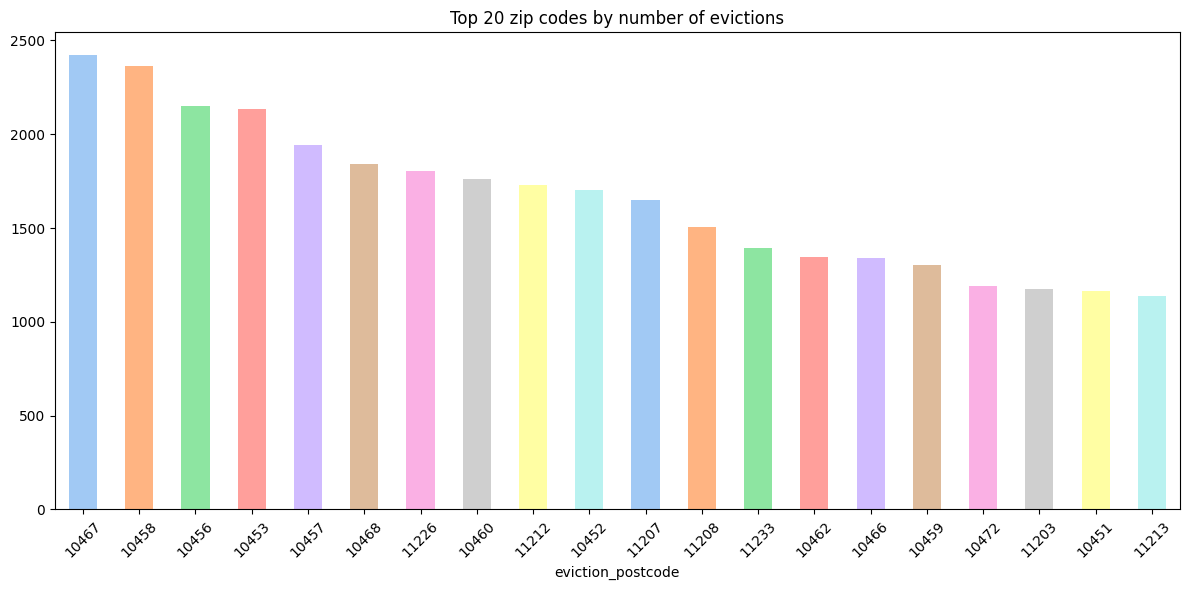

In [546]:
# top postal codes
plt.figure(figsize=(12, 6))
evictions_df['eviction_postcode'].value_counts().head(20).plot(kind='bar',
                                                              color=pastel_colors)
plt.title('Top 20 zip codes by number of evictions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [549]:
# with %
zip_counts = evictions_df['eviction_postcode'].value_counts().head(20)
total_evictions = len(evictions_df)
print("Top 20 zip codes by number of evictions:")
print("Zip Code | Number of Evictions | % of Total")
print("-" * 45)
for zip_code, count in zip_counts.items():
    percentage = (count / total_evictions) * 100
    print(f"{zip_code:^8} | {count:^17} | {percentage:^8.2f}%")


Top 20 zip codes by number of evictions:

Zip Code | Number of Evictions | % of Total
---------------------------------------------
 10467   |       2422        |   3.01  %
 10458   |       2363        |   2.94  %
 10456   |       2150        |   2.67  %
 10453   |       2133        |   2.65  %
 10457   |       1941        |   2.41  %
 10468   |       1843        |   2.29  %
 11226   |       1804        |   2.24  %
 10460   |       1759        |   2.19  %
 11212   |       1729        |   2.15  %
 10452   |       1702        |   2.12  %
 11207   |       1648        |   2.05  %
 11208   |       1508        |   1.88  %
 11233   |       1394        |   1.73  %
 10462   |       1348        |   1.68  %
 10466   |       1340        |   1.67  %
 10459   |       1305        |   1.62  %
 10472   |       1189        |   1.48  %
 11203   |       1173        |   1.46  %
 10451   |       1163        |   1.45  %
 11213   |       1140        |   1.42  %


#### community boards

In [534]:
# community board mappings by borough
# source: https://www.nyc.gov/site/cau/community-boards/about-commmunity-boards.page

cb_names = {
    # Manhattan (1-12)
    1: "Financial District/Tribeca",
    2: "Greenwich Village/Little Italy/SoHo/NoHo",
    3: "Lower East Side/Chinatown",
    4: "Chelsea/Clinton/Hudson Yards",
    5: "Midtown",
    6: "Stuyvesant Town/Tudor City",
    7: "Upper West Side/Manhattan Valley",
    8: "Upper East Side",
    9: "Hamilton Heights/Morningside Heights/Manhattanville",
    10: "Central Harlem",
    11: "East Harlem",
    12: "Inwood/Washington Heights",

    # Bronx (201-212)
    201: "Mott Haven/Melrose/Port Morris",
    202: "Hunts Point/Longwood",
    203: "Morrisania/Crotona",
    204: "Highbridge/Concourse",
    205: "Morris Heights/Fordham South/Mount Hope",
    206: "Belmont/East Tremont/Bathgate",
    207: "Kingsbridge Heights/Bedford Park/Fordham/University Heights",
    208: "Riverdale/Kingsbridge/Marble Hill",
    209: "Parkchester/Unionport/Soundview",
    210: "Throgs Neck/Co-op City/Pelham Bay",
    211: "Morris Park/Bronxdale/Pelham Parkway",
    212: "Williamsbridge/Baychester",

    # Brooklyn (301-318)
    301: "Brooklyn Heights/DUMBO/Downtown Brooklyn",
    302: "Fort Greene/Brooklyn Navy Yard/Clinton Hill",
    303: "Bedford-Stuyvesant",
    304: "Bushwick",
    305: "East New York/Cypress Hills",
    306: "Red Hook/Park Slope",
    307: "Sunset Park/Windsor Terrace",
    308: "Crown Heights/Prospect Heights",
    309: "South Crown Heights/Prospect Lefferts Gardens",
    310: "Bay Ridge/Dyker Heights",
    311: "Bensonhurst/Bath Beach",
    312: "Borough Park/Ocean Parkway",
    313: "Coney Island/Brighton Beach",
    314: "Flatbush/Midwood",
    315: "Sheepshead Bay/Manhattan Beach/Gerritsen Beach",
    316: "Brownsville",
    317: "East Flatbush",
    318: "Flatlands/Canarsie",

    # Queens (401-414)
    401: "Astoria",
    402: "Sunnyside/Woodside",
    403: "Jackson Heights",
    404: "Elmhurst/Corona",
    405: "Ridgewood/Maspeth/Middle Village",
    406: "Rego Park/Forest Hills",
    407: "Flushing/Murray Hill/Whitestone",
    408: "Fresh Meadows/Briarwood",
    409: "Kew Gardens/Richmond Hill",
    410: "South Ozone Park/Howard Beach",
    411: "Bayside/Douglaston/Little Neck",
    412: "Jamaica/St. Albans/Hollis",
    413: "Queens Village/Rosedale",
    414: "Rockaway/Broad Channel",

    # Staten Island (501-503)
    501: "St. George/Stapleton",
    502: "South Beach/Willowbrook",
    503: "Tottenville/Great Kills"
}

In [544]:
# Council District mappings
# source: https://council.nyc.gov/districts/

cd_names = {
    # Manhattan
    1: "Lower Manhattan/Chinatown/Lower East Side",
    2: "East Village/Gramercy/Kips Bay",
    3: "Greenwich Village/Chelsea/Hell's Kitchen",
    4: "Upper East Side/East Midtown",
    5: "Upper East Side/Roosevelt Island/Sutton Place",
    6: "Upper West Side/Central Park",
    7: "Upper West Side/Manhattan Valley/Morningside Heights",
    8: "East Harlem/Mott Haven/Randall's Island",
    9: "Central Harlem/Morningside Heights/Upper West Side",
    10: "Central Harlem/East Harlem",

    # Brooklyn
    33: "Brooklyn Heights/Greenpoint/Williamsburg",
    34: "Bushwick/Ridgewood",
    35: "Fort Greene/Clinton Hill/Crown Heights",
    36: "Bedford-Stuyvesant/Crown Heights",
    37: "Bushwick/East New York/Cypress Hills",
    38: "Red Hook/Sunset Park/Windsor Terrace",
    39: "Cobble Hill/Park Slope/Prospect Heights",
    40: "Crown Heights/East Flatbush/Prospect Lefferts Gardens",
    41: "Bedford-Stuyvesant/Ocean Hill-Brownsville",
    42: "East New York/New Lots/Spring Creek",
    43: "Bay Ridge/Dyker Heights",
    44: "Bensonhurst/Borough Park",
    45: "Flatbush/Flatlands/Midwood",
    46: "Bergen Beach/Canarsie/Mill Basin",
    47: "Bensonhurst/Gravesend/Coney Island",
    48: "Brighton Beach/Manhattan Beach/Sheepshead Bay",

    # Bronx
    11: "Bedford Park/Morris Park/Riverdale/Wakefield",
    12: "Wakefield/Williamsbridge",
    13: "Allerton/City Island/Throgs Neck",
    14: "Morris Heights/University Heights/Fordham",
    15: "Bedford Park/Fordham/Mount Hope/Bathgate",
    16: "Claremont/Concourse/Morrisania",
    17: "Hunts Point/Longwood/Melrose",
    18: "Soundview/Parkchester",

    # Queens
    19: "College Point/Whitestone",
    20: "Downtown Flushing/Murray Hill",
    21: "Bayside/College Point/Fresh Meadows",
    22: "Astoria/East Elmhurst/Jackson Heights",
    23: "Fresh Meadows/Hollis/Queens Village",
    24: "Fresh Meadows/Jamaica Estates",
    25: "Elmhurst/Jackson Heights",
    26: "Long Island City/Sunnyside/Woodside",
    27: "Cambria Heights/Hollis/Jamaica",
    28: "Jamaica/Richmond Hill/Rochdale Village",
    29: "Forest Hills/Rego Park",
    30: "Glendale/Maspeth/Middle Village",
    31: "Arverne/Far Rockaway",
    32: "Belle Harbor/Breezy Point/Howard Beach",

    # Staten Island
    49: "North Shore",
    50: "Mid-Island",
    51: "South Shore"
}

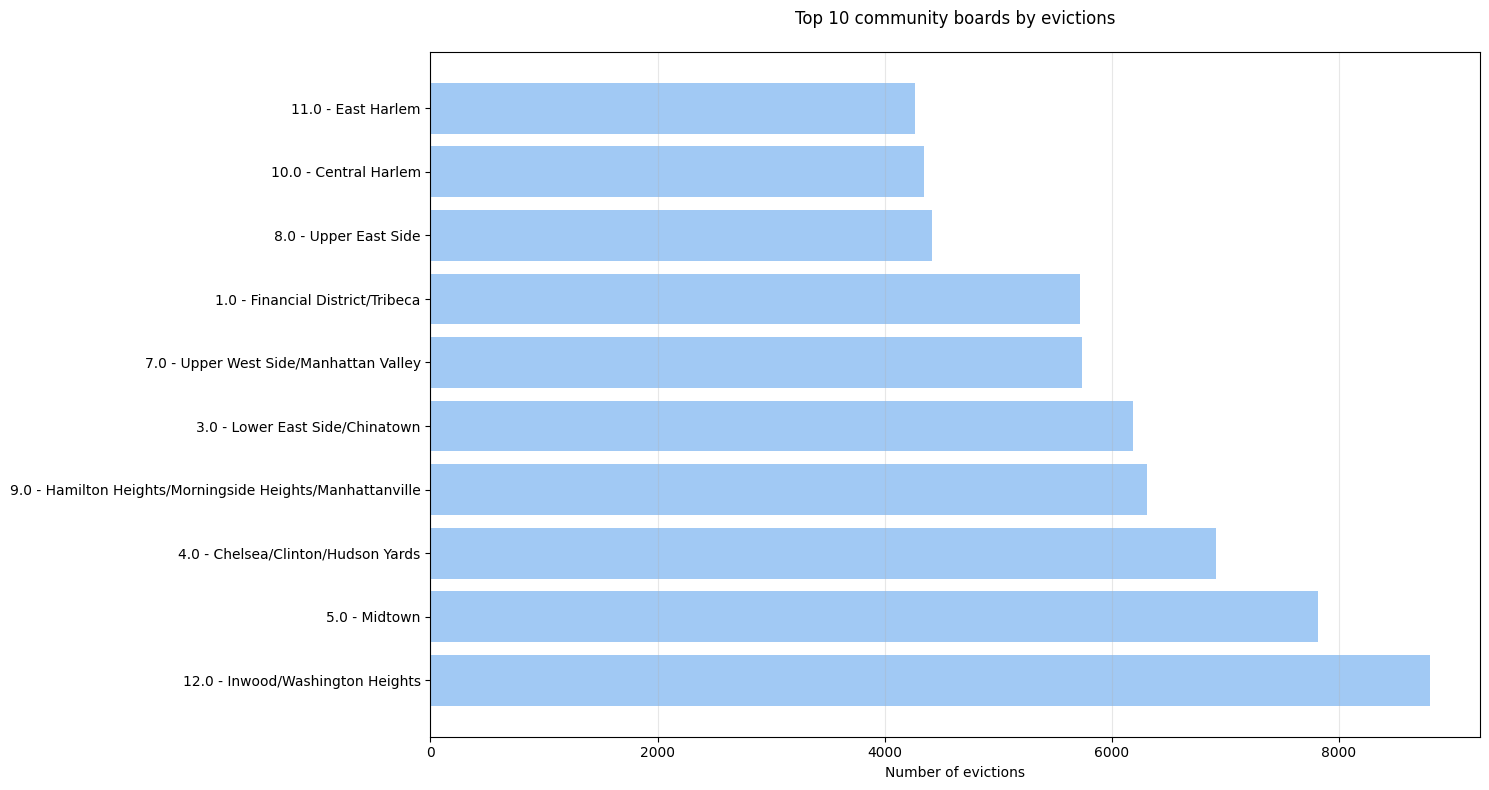

In [536]:
cb_counts = evictions_df['community_board'].value_counts()
cb_df = pd.DataFrame({
    'district_number': cb_counts.index,
    'eviction_count': cb_counts.values
})
cb_df['district_name'] = cb_df['district_number'].map(cb_names)
cb_df = cb_df.sort_values('eviction_count', ascending=False)

plt.figure(figsize=(15, 8))
plt.barh(
    range(10),
    cb_df['eviction_count'].head(10),
    color=sns.color_palette("pastel")[0]
)

# labels for Community Boards
plt.yticks(
    range(10),
    [f"{num} - {name}" for num, name in
     zip(cb_df['district_number'].head(10),
         cb_df['district_name'].head(10))],
    fontsize=10
)

plt.title('Top 10 community boards by evictions', pad=20)
plt.xlabel('Number of evictions')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

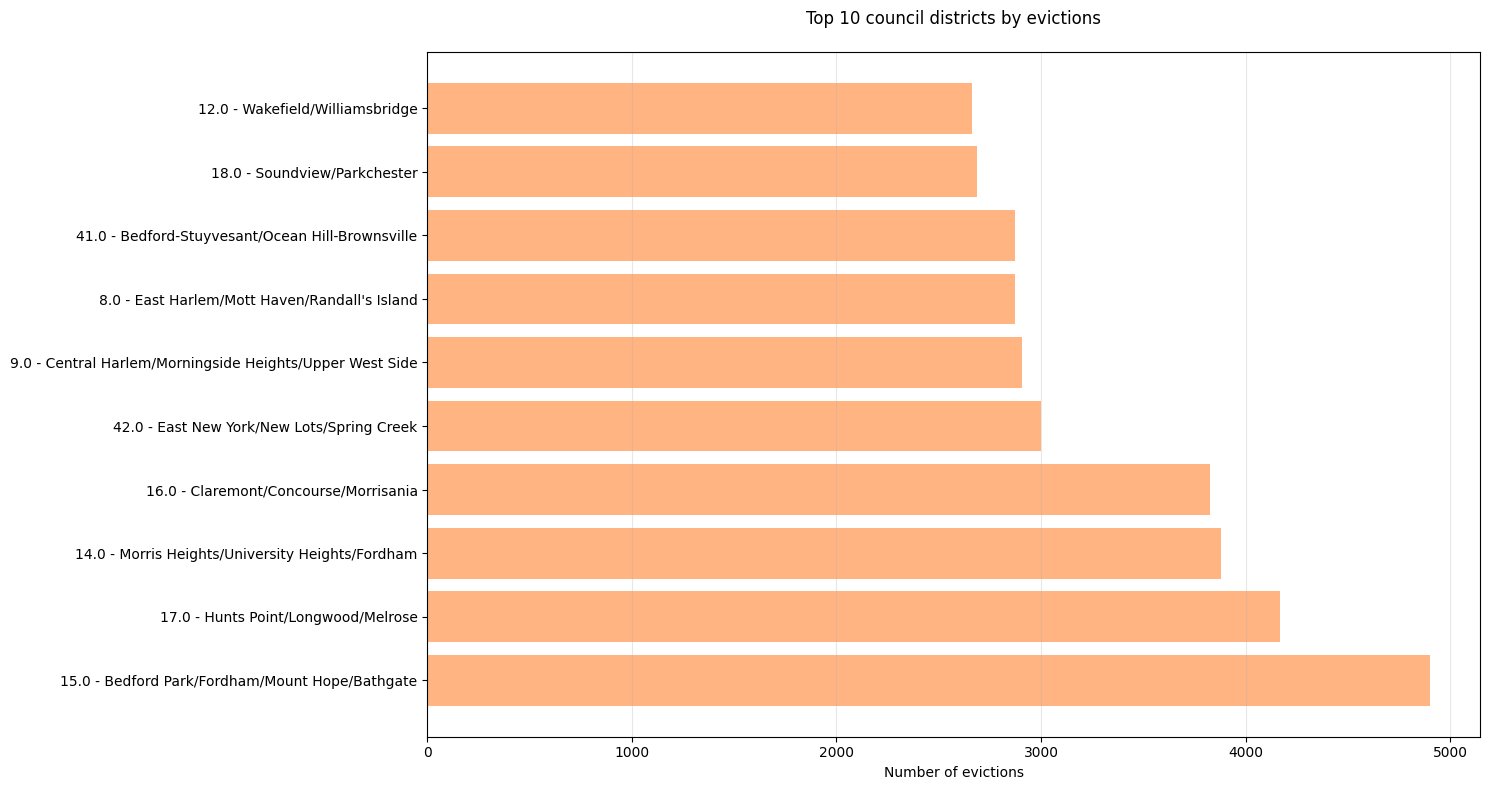

In [537]:
# Council District
cd_counts = evictions_df['council_district'].value_counts()

cd_df = pd.DataFrame({
    'district_number': cd_counts.index,
    'eviction_count': cd_counts.values
})

cd_df['district_name'] = cd_df['district_number'].map(cd_names)
cd_df = cd_df.sort_values('eviction_count', ascending=False)

plt.figure(figsize=(15, 8))
plt.barh(
    range(10),
    cd_df['eviction_count'].head(10),
    color=sns.color_palette("pastel")[1]
)

# labels for council districts
plt.yticks(
    range(10),
    [f"{num} - {name}" for num, name in
     zip(cd_df['district_number'].head(10),
         cd_df['district_name'].head(10))],
    fontsize=10
)

plt.title('Top 10 council districts by evictions', pad=20)
plt.xlabel('Number of evictions')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [538]:
print("Top 10 community boards by evictions:")
print(cb_df[['district_number', 'district_name', 'eviction_count']].head(10).to_string())

print("Top 10 council districts by evictions:")
print(cd_df[['district_number', 'district_name', 'eviction_count']].head(10).to_string())

Top 10 community boards by evictions:
   district_number                                        district_name  eviction_count
0             12.0                            Inwood/Washington Heights            8801
1              5.0                                              Midtown            7813
2              4.0                         Chelsea/Clinton/Hudson Yards            6918
3              9.0  Hamilton Heights/Morningside Heights/Manhattanville            6312
4              3.0                            Lower East Side/Chinatown            6187
5              7.0                     Upper West Side/Manhattan Valley            5735
6              1.0                           Financial District/Tribeca            5717
7              8.0                                      Upper East Side            4412
8             10.0                                       Central Harlem            4347
9             11.0                                          East Harlem           

#### community boards are the governining entities of neighborhoods and the council districts serve similar purpose.

#### neighborhood trends

In [539]:
evictions_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80420 entries, 7797 to 21704
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   court_index_number         80420 non-null  object        
 1   docket_number              80420 non-null  int64         
 2   eviction_address           80420 non-null  object        
 3   eviction_apartment_number  80420 non-null  object        
 4   executed_date              80420 non-null  datetime64[ns]
 5   borough                    80420 non-null  object        
 6   eviction_postcode          80420 non-null  int64         
 7   ejectment                  80420 non-null  object        
 8   eviction/legal_possession  80420 non-null  object        
 9   latitude                   80420 non-null  float64       
 10  longitude                  80420 non-null  float64       
 11  community_board            80420 non-null  float64       
 12  counci

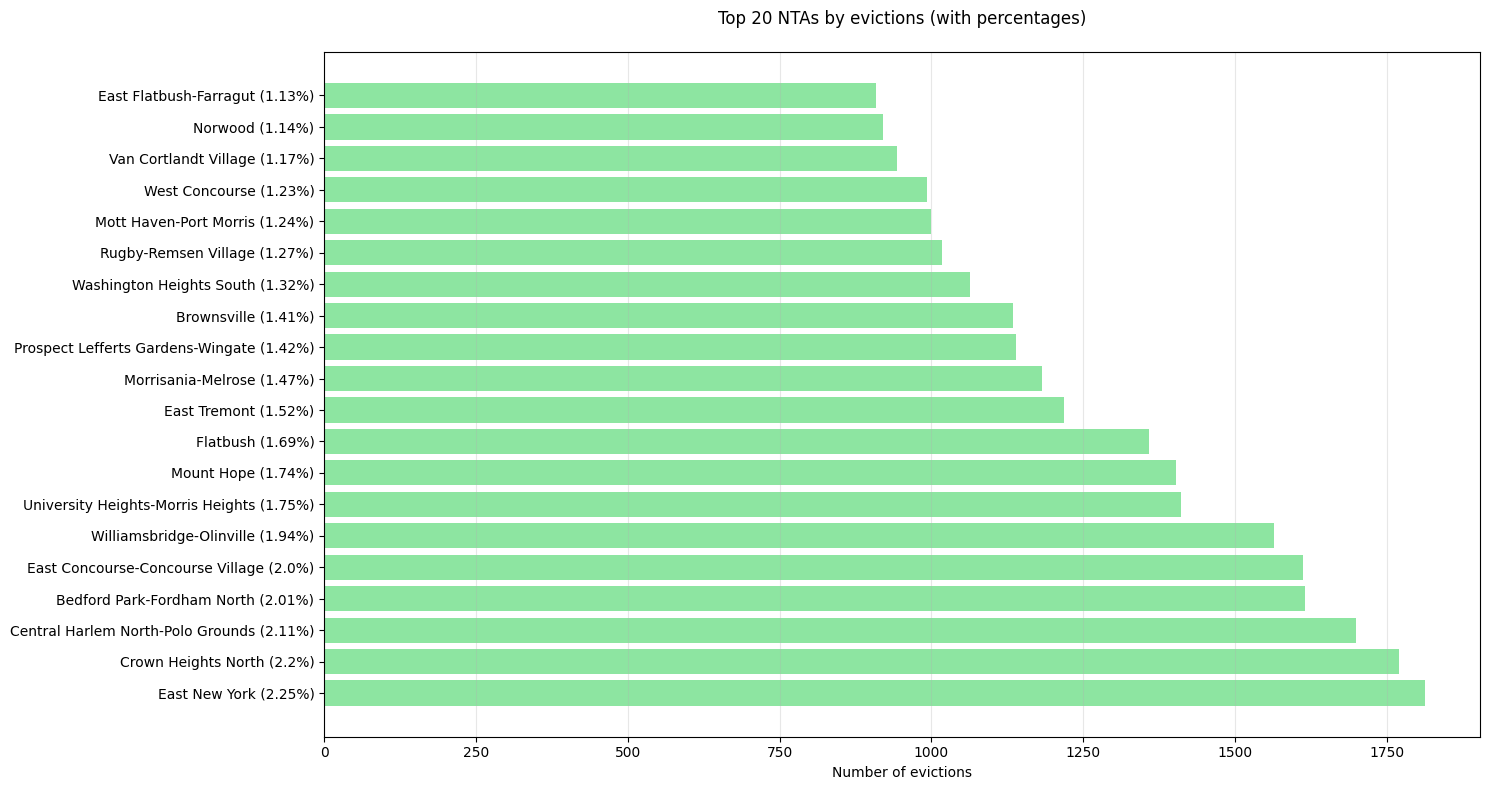

In [540]:
# nta %
nta_counts = evictions_df['nta'].value_counts()
total_evictions = nta_counts.sum()
nta_analysis = pd.DataFrame({
    'eviction_count': nta_counts,
    'percentage': (nta_counts / total_evictions * 100).round(2)
})

nta_analysis = nta_analysis.sort_values('eviction_count', ascending=False)

plt.figure(figsize=(15, 8))
bars = plt.barh(
    range(20),
    nta_analysis['eviction_count'].head(20),
    color=sns.color_palette("pastel")[2]
)

plt.yticks(
    range(20),
    [f"{name} ({pct}%)" for name, pct in
     zip(nta_analysis.head(20).index,
         nta_analysis['percentage'].head(20))],
    fontsize=10
)

plt.title('Top 20 NTAs by evictions (with percentages)', pad=20)
plt.xlabel('Number of evictions')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [541]:
print("Top 20 NTAs by evictions:")
print(nta_analysis.head(20).to_string())

Top 20 NTAs by evictions:
                                   eviction_count  percentage
nta                                                          
East New York                                1813        2.25
Crown Heights North                          1771        2.20
Central Harlem North-Polo Grounds            1700        2.11
Bedford Park-Fordham North                   1615        2.01
East Concourse-Concourse Village             1612        2.00
Williamsbridge-Olinville                     1564        1.94
University Heights-Morris Heights            1411        1.75
Mount Hope                                   1403        1.74
Flatbush                                     1358        1.69
East Tremont                                 1219        1.52
Morrisania-Melrose                           1183        1.47
Prospect Lefferts Gardens-Wingate            1140        1.42
Brownsville                                  1134        1.41
Washington Heights South                    

In [542]:
evictions_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80420 entries, 7797 to 21704
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   court_index_number         80420 non-null  object        
 1   docket_number              80420 non-null  int64         
 2   eviction_address           80420 non-null  object        
 3   eviction_apartment_number  80420 non-null  object        
 4   executed_date              80420 non-null  datetime64[ns]
 5   borough                    80420 non-null  object        
 6   eviction_postcode          80420 non-null  int64         
 7   ejectment                  80420 non-null  object        
 8   eviction/legal_possession  80420 non-null  object        
 9   latitude                   80420 non-null  float64       
 10  longitude                  80420 non-null  float64       
 11  community_board            80420 non-null  float64       
 12  counci

In [543]:
# save cleaned evictions data to my drive
sorted_df.to_csv('/content/drive/My Drive/X999/evictions_df_cleaned.csv', index=False)